In [128]:
%matplotlib inline

import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import stats
import warnings

import regress_utils as ru

In [137]:
import importlib
importlib.reload(ru)

<module 'regress_utils' from '/home/jovyan/v2/cmip6-seaice-temp-sensitivity/notebooks/rc_notebooks/regress_utils.py'>

#### Load dataset

In [69]:
# Load dataset
collection_fname = 'dset_dict_historical.npy'
#collection_fname = 'dset_dict_piControl.npy'

dset_dict = np.load(collection_fname, allow_pickle='TRUE').item()
first_dset = list(dset_dict.keys())[0]
models_intersect = dset_dict[first_dset].keys()

#### Regression of sea ice extent on arctic temperature for each model for multiple ensemble members

In [70]:
# Set maximum number of ensemble members to look at for each model
#N.B. doing this for anomalies give you the same answer as not anomalies. Which makes sense when you think about it.
max_ems = 5

warnings.filterwarnings('ignore')

slopes_all, r_all = {}, {}
for m in models_intersect:
    # get ensemble members
    ems = dset_dict['siconc'][m]['member_id'].values
    if len(ems)>max_ems:
        ems = ems[0:max_ems]
    print(m, len(ems))
    
    # Perform regression
    slopes_all[m], r_all[m] = {}, {}
    for i, em in enumerate(ems):
        print(em)
        slopes_all[m][i], r_all[m][i] = ru.scatter_tas_SIE_linreg(
                                                        dset_dict['tas'][m]['tas_arc_mean'].sel(member_id=em),
                                                        dset_dict['siconc'][m]['sie_tot_arc'].sel(member_id=em),
                                                        [2,8], False, m)

warnings.filterwarnings('default')

MPI-ESM1-2-LR 5
r8i1p1f1
r1i1p1f1
r6i1p1f1
r9i1p1f1
r5i1p1f1
MIROC6 5
r8i1p1f1
r1i1p1f1
r6i1p1f1
r9i1p1f1
r5i1p1f1
CESM2-FV2 1
r1i1p1f1
NorESM2-LM 1
r2i1p1f1
MPI-ESM-1-2-HAM 2
r1i1p1f1
r2i1p1f1
SAM0-UNICON 1
r1i1p1f1
ACCESS-CM2 2
r1i1p1f1
r2i1p1f1
MPI-ESM1-2-HR 5
r8i1p1f1
r1i1p1f1
r6i1p1f1
r9i1p1f1
r5i1p1f1
MIROC-ES2L 3
r3i1p1f2
r1i1p1f2
r2i1p1f2
CESM2-WACCM-FV2 1
r1i1p1f1
ACCESS-ESM1-5 3
r1i1p1f1
r2i1p1f1
r3i1p1f1
CESM2 5
r8i1p1f1
r6i1p1f1
r11i1p1f1
r1i1p1f1
r9i1p1f1
NorCPM1 4
r26i1p1f1
r23i1p1f1
r17i1p1f1
r24i1p1f1
CanESM5 5
r8i1p1f1
r13i1p1f1
r13i1p2f1
r11i1p1f1
r7i1p2f1
CanESM5-CanOE 3
r1i1p2f1
r2i1p2f1
r3i1p2f1
MRI-ESM2-0 5
r1i1p1f1
r5i1p1f1
r4i1p1f1
r3i1p1f1
r2i1p1f1


In [71]:
# Calculate ensemble mean and r values for each model
slopes_mean, r_mean = {}, {}

print('Model, slopes (mar, sept), r (mar, sept)')
print()
for m in models_intersect:
    slopes_mean_temp, r_mean_temp = [], []
    for em in slopes_all[m].keys():
        slopes_mean_temp.append(slopes_all[m][em])
        r_mean_temp.append(r_all[m][em])        
        
    slopes_mean[m] = np.mean(slopes_mean_temp,0)
    r_mean[m] = np.mean(r_mean_temp,0)
    
    print(m, slopes_mean[m], r_mean[m])

Model, slopes (mar, sept), r (mar, sept)

MPI-ESM1-2-LR [-0.0239203  -0.43335735] [-0.16768291 -0.21512079]
MIROC6 [-0.10432816 -0.61699036] [-0.50384465 -0.83007906]
CESM2-FV2 [-0.04049284 -0.92662303] [-0.23447136 -0.73824288]
NorESM2-LM [-0.04339587 -0.61937929] [-0.25928011 -0.63112629]
MPI-ESM-1-2-HAM [-0.00918958 -0.06211326] [-0.098662   -0.04074272]
SAM0-UNICON [-0.09876842 -0.39225192] [-0.32149741 -0.73354963]
ACCESS-CM2 [-0.18163913 -0.65066614] [-0.39708171 -0.77835184]
MPI-ESM1-2-HR [-0.0902566 -0.5902514] [-0.33244858 -0.33638185]
MIROC-ES2L [-0.09192133 -0.65859899] [-0.36098676 -0.82239082]
CESM2-WACCM-FV2 [-0.04315566 -0.71979453] [-0.27963064 -0.69283106]
ACCESS-ESM1-5 [-0.19504076 -0.53949328] [-0.49922439 -0.68638816]
CESM2 [-0.08672367 -1.19499295] [-0.51238284 -0.82860222]
NorCPM1 [-0.01273068 -0.07832514] [0.22555631 0.13553463]
CanESM5 [-0.21402902 -0.52212338] [-0.60222016 -0.81597729]
CanESM5-CanOE [-0.18316136 -0.46589789] [-0.48428173 -0.76030876]
MRI-ESM2-0

#### Save

In [72]:
# Save dictionaries for future use
results_fname = 'results_' + collection_fname[10:]
save_flag = True
if save_flag:
    if dset_dict:
        np.save(results_fname, slopes_mean, r_mean)

#### Plots

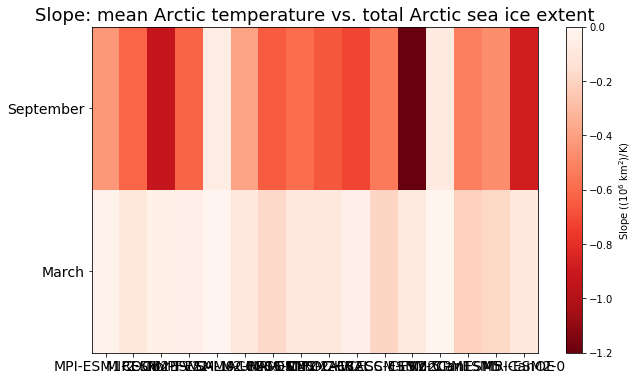

In [73]:
# Plot slopes for all models
slopes_plot = np.zeros((2,len(slopes_mean.keys())))

for im, m in enumerate(slopes_mean.keys()):
    slopes_plot[0,im] = slopes_mean[m][0]
    slopes_plot[1,im] = slopes_mean[m][1]
    
fig = plt.figure(figsize=(10,6))
plt.pcolormesh(slopes_plot, cmap='Reds_r')
plt.clim(0, -1.2)
plt.xticks(np.arange(0, len(models_intersect), 1) + 0.5,list(slopes_all.keys()),fontsize=14)
plt.yticks([0.5,1.5],['March','September'],fontsize=14)
plt.title('Slope: mean Arctic temperature vs. total Arctic sea ice extent', fontsize=18)
plt.colorbar(label='Slope ((10$^{6}$ km$^{2}$)/K)')

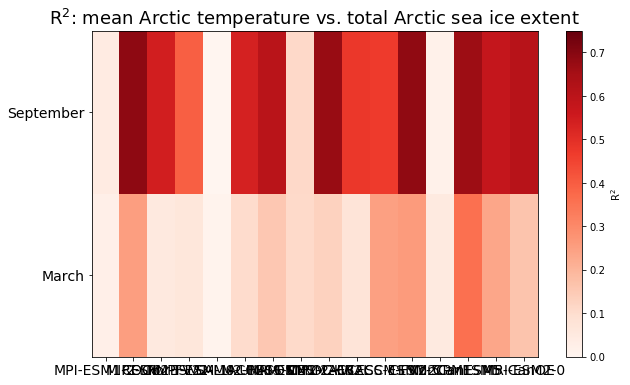

In [74]:
# Plot R squared for all models
r_plot = np.zeros((2,len(r_mean.keys())))

for im, m in enumerate(r_mean.keys()):
    r_plot[0,im] = r_mean[m][0]*r_mean[m][0]
    r_plot[1,im] = r_mean[m][1]*r_mean[m][1]
    
fig = plt.figure(figsize=(10,6))
plt.pcolormesh(r_plot, cmap='Reds')
plt.clim(0, 0.75)
plt.xticks(np.arange(0, len(models_intersect), 1) + 0.5,list(slopes_all.keys()),fontsize=14)
plt.yticks([0.5,1.5],['March','September'],fontsize=14)
plt.title('R$^{2}$: mean Arctic temperature vs. total Arctic sea ice extent', fontsize=18)
plt.colorbar(label='R$^{2}$')

### Sorting by September slope

In [75]:
dumb = {}
dumb_name = {}
for n,name in enumerate(slopes_mean.keys()):
    dumb[n] = slopes_mean[name][1]
    dumb_name[n] = name

In [76]:
dumb_sorted = {k: v for k, v in sorted(dumb.items(), key=lambda item: item[1])}
slopes_sorted = {}
r_sorted = {}

for n in dumb_sorted.keys():
    slopes_sorted[dumb_name[n]] = slopes_mean[dumb_name[n]]
    r_sorted[dumb_name[n]] = r_mean[dumb_name[n]]

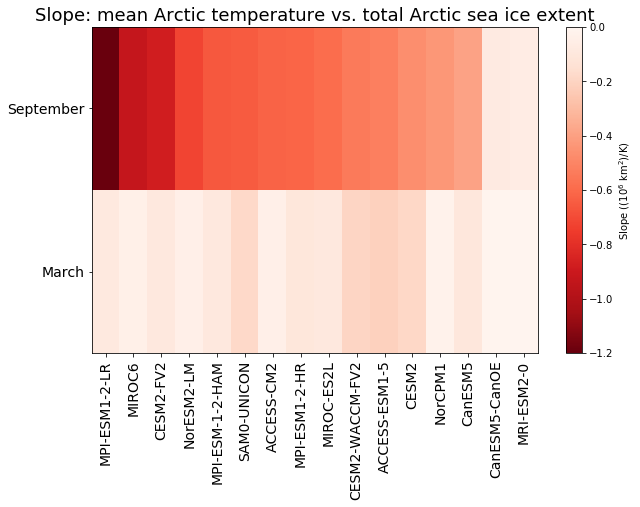

In [79]:
# Plot slopes for all models
slopes_splot = np.zeros((2,len(slopes_mean.keys())))

for im, m in enumerate(slopes_sorted.keys()):
    slopes_splot[0,im] = slopes_sorted[m][0]
    slopes_splot[1,im] = slopes_sorted[m][1]
    
fig = plt.figure(figsize=(10,6))
plt.pcolormesh(slopes_splot, cmap='Reds_r')
plt.clim(0, -1.2)
plt.xticks(np.arange(0, len(models_intersect), 1) + 0.5,list(slopes_all.keys()),fontsize=14, 
           rotation='vertical')
plt.yticks([0.5,1.5],['March','September'],fontsize=14)
plt.title('Slope: mean Arctic temperature vs. total Arctic sea ice extent', fontsize=18)
plt.colorbar(label='Slope ((10$^{6}$ km$^{2}$)/K)')

In [ ]:
# Plot R squared for all models
r_plot = np.zeros((2,len(r_mean.keys())))

for im, m in enumerate(r_mean.keys()):
    r_splot[0,im] = r_sorted[m][0]*r_mean[m][0]
    r_splot[1,im] = r_sorted[m][1]*r_mean[m][1]
    
fig = plt.figure(figsize=(10,6))
plt.pcolormesh(r_splot, cmap='Reds')
plt.clim(0, 0.75)
plt.xticks(np.arange(0, len(models_intersect), 1) + 0.5,list(slopes_all.keys()),
           fontsize=14,rotation='vertical')
plt.yticks([0.5,1.5],['March','September'],fontsize=14)
plt.title('R$^{2}$: mean Arctic temperature vs. total Arctic sea ice extent', fontsize=18)
plt.colorbar(label='R$^{2}$')

In [135]:
TAS_ARCTIC_IN = dset_dict['tas']['CESM2']['tas_arc_mean'].sel(member_id='r1i1p1f1')
SIE_ARCTIC_IN = dset_dict['siconc']['CESM2']['sie_tot_arc'].sel(member_id='r1i1p1f1')
MONTHS_IN = [0,1,2]
PLOTFLAG = True
MODEL = 'CESM2'
import calendar

0


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


1


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


2


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


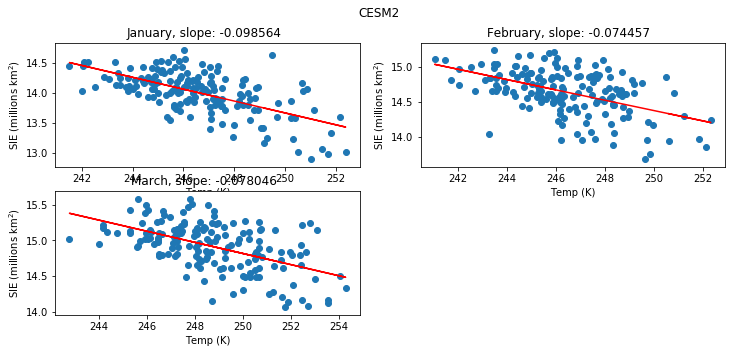

In [138]:
sall, rall, intall = ru.scatter_linreg(TAS_ARCTIC_IN,SIE_ARCTIC_IN,MONTHS_IN,MODEL,True)